In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon_EnetV2_OpenMax/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import os
import torch
import numpy as np
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
from dataset import CANDatasetEnet as CANDataset
from rd_openmax import openmax_predict_rd
from model_init import *
from torchvision import transforms
from torch.utils.data import DataLoader


In [ ]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device("cuda:1")

In [ ]:
data_paths = {
    "close": "../data/set_04/test_01_known_vehicle_known_attack/preprocessed/5_percent/TFRecord_w64_s32/2",
    "open_all": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/TFRecord_w64_s32/2",
    "open_dos": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/dos/TFRecord_w64_s32/2",
    "open_double": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/triple/TFRecord_w64_s32/2",
    "open_force_neutral": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/force-neutral/TFRecord_w64_s32/2",
    "open_fuzzing": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/fuzzing/TFRecord_w64_s32/2",
    "open_triple": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/triple/TFRecord_w64_s32/2"
}

n_classes = 6
batch_size = 128
window_size = 32


In [14]:
# Load datasets
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def create_loader(path, batch_size=batch_size, is_train=False):
    dataset = CANDataset(root_dir=path, window_size=window_size, is_train=is_train, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, loader


In [6]:
datasets = {}
loaders = {}

for key, path in data_paths.items():
    datasets[key], loaders[key] = create_loader(path)

In [15]:
# Configuration

# /home/hieutt/UniCon_EnetV2_OpenMax/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_epoch_138.pth
# ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_epoch_138.pth"
# class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_classifier_epoch_138.pth"
# weibull_path = ckpt_path.replace("ckpt_epoch_138.pth", "weibull_epoch_138.pkl")

#/home/hieutt/UniCon_EnetV2_OpenMax/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.03_decay_0.0001_bsz_128_trial_F-DEF_v2_cosine_warm
ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.03_decay_0.0001_bsz_128_trial_F-DEF_v2_cosine_warm/ckpt_epoch_66.pth"
class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.03_decay_0.0001_bsz_128_trial_F-DEF_v2_cosine_warm/ckpt_classifier_epoch_66.pth"
weibull_path = ckpt_path.replace("ckpt_epoch_66.pth", "weibull_epoch_66.pkl")

In [8]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [16]:
from networks.con_mpncovresnet import ConTinyMPNCOVResNet, LinearClassifier
model = ConTinyMPNCOVResNet(
    attention='Cov',
    input_size=64,
    feat_dim=128
)
classifier = LinearClassifier(input_dim=8256, num_classes=n_classes)

ckpt = torch.load(ckpt_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

# 3. Load Weibull models
with open(weibull_path, 'rb') as f:
    weibull_data = pickle.load(f)
class_means = weibull_data['class_means']
weibull_models = weibull_data['weibull_models']

model.to(device)
classifier.to(device)

LinearClassifier(
  (fc): Linear(in_features=8256, out_features=6, bias=True)
)

In [17]:
def evaluate_open_set(model, classifier, open_loader, class_means, weibull_models, device, best_thresh=0.7212):
    total_preds = []
    total_feats = []
    total_labels = []
    unk_probs = []

    model.eval()
    if classifier is not None:
        classifier.eval()

    with torch.no_grad():
        for images, labels in open_loader:
            if isinstance(images, (list, tuple)):
                images = images[0]

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # 🧠 Feature embedding
            feats = model.encoder(images) if classifier is not None else model(images)
            feats = F.normalize(feats, dim=1)
            feats_np = feats.cpu().numpy()
            total_feats.append(feats_np)

            for f, label in zip(feats_np, labels.cpu().numpy()):
                pred_class, unk_prob = openmax_predict_rd(f, class_means, weibull_models)
                total_preds.append((pred_class, unk_prob))
                total_labels.append(label)
                unk_probs.append(unk_prob)

    total_feats_np = np.concatenate(total_feats, axis=0)

    # Mapping labels: 0 = known, else = unknown
    mapped_label = [0 if l == 0 else 1 for l in total_labels]
    mapped_pred = [0 if p[1] < best_thresh else 1 for p in total_preds]

    return {
        "mapped_label": mapped_label,
        "mapped_pred": mapped_pred,
        "unk_probs": unk_probs,
        "total_feats": total_feats_np,
        "raw_preds": total_preds,
        "labels": total_labels
    }


In [18]:
results = {}
for name in ['open_all', 'open_dos', 'open_double', 'open_force_neutral', 'open_fuzzing', 'open_triple']:
    print(f"🔍 Evaluating on: {name}")
    res = evaluate_open_set(
        model=model,
        classifier=classifier,
        open_loader=loaders[name],
        class_means=class_means,
        weibull_models=weibull_models,
        device=device,
        best_thresh=0.7454
    )
    results[name] = res

🔍 Evaluating on: open_all
🔍 Evaluating on: open_dos
🔍 Evaluating on: open_double
🔍 Evaluating on: open_force_neutral
🔍 Evaluating on: open_fuzzing
🔍 Evaluating on: open_triple


In [12]:
# 📊 Evaluation
def evaluate_and_print_metrics(results_dict):
    """
    results_dict: dictionary dạng {dataset_name: result_dict}
    Trong đó result_dict chứa:
        - mapped_label
        - mapped_pred
    """
    for name, res in results_dict.items():
        y_true = res['mapped_label']
        y_pred = res['mapped_pred']
        
        acc = accuracy_score(y_true, y_pred) * 100
        f1 = f1_score(y_true, y_pred, average='binary')
        precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='binary')
        conf_matrix = confusion_matrix(y_true, y_pred)

        print(f"\n📁 Dataset: {name}")
        print(f"🔹 Accuracy: {acc:.2f}%")
        print(f"🔹 F1 Score: {f1:.4f}")
        print(f"🔹 Precision: {precision:.4f}")
        print(f"🔹 Recall: {recall:.4f}")
        print("🔹 Confusion Matrix:")
        print(conf_matrix)

In [19]:
# 📊 Result
evaluate_and_print_metrics(results)


📁 Dataset: open_all
🔹 Accuracy: 13.52%
🔹 F1 Score: 0.2184
🔹 Precision: 0.1229
🔹 Recall: 0.9797
🔹 Confusion Matrix:
[[  617 36928]
 [  107  5173]]

📁 Dataset: open_dos
🔹 Accuracy: 13.58%
🔹 F1 Score: 0.1948
🔹 Precision: 0.1080
🔹 Recall: 0.9910
🔹 Confusion Matrix:
[[  66 1825]
 [   2  221]]

📁 Dataset: open_double
🔹 Accuracy: 30.21%
🔹 F1 Score: 0.4614
🔹 Precision: 0.2999
🔹 Recall: 1.0000
🔹 Confusion Matrix:
[[   6 1361]
 [   0  583]]

📁 Dataset: open_force_neutral
🔹 Accuracy: 9.13%
🔹 F1 Score: 0.1574
🔹 Precision: 0.0854
🔹 Recall: 1.0000
🔹 Confusion Matrix:
[[  10 1424]
 [   0  133]]

📁 Dataset: open_fuzzing
🔹 Accuracy: 11.15%
🔹 F1 Score: 0.1654
🔹 Precision: 0.0912
🔹 Recall: 0.8911
🔹 Confusion Matrix:
[[  48 1794]
 [  22  180]]

📁 Dataset: open_triple
🔹 Accuracy: 30.21%
🔹 F1 Score: 0.4614
🔹 Precision: 0.2999
🔹 Recall: 1.0000
🔹 Confusion Matrix:
[[   6 1361]
 [   0  583]]


In [112]:
def plot_all_metrics(result, dataset_name=""):
    unk_probs = result['unk_probs']
    targets = result['mapped_label']
    preds = result['mapped_pred']

    fpr, tpr, _ = roc_curve(targets, unk_probs)
    auc = roc_auc_score(targets, unk_probs)
    cm = confusion_matrix(targets, preds)

    df = pd.DataFrame({
        'Unknown Probability': unk_probs,
        'Class': ['Unknown' if t == 1 else 'Known' for t in targets]
    })

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ Violin plot
    sns.violinplot(x='Class', y='Unknown Probability', hue='Class',
                   data=df, palette='Set2', ax=axs[0], legend=False)
    axs[0].set_title('Unknown Probabilities')

    # 2️⃣ Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Known', 'Unknown'],
                yticklabels=['Known', 'Unknown'], ax=axs[1])
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    # 3️⃣ ROC curve
    axs[2].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    axs[2].plot([0, 1], [0, 1], '--', color='gray')
    axs[2].set_title('ROC Curve')
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].legend()
    axs[2].grid(True)


    fig.suptitle(f"Visualization for {dataset_name}", fontsize=16)
    plt.tight_layout()
    plt.show()


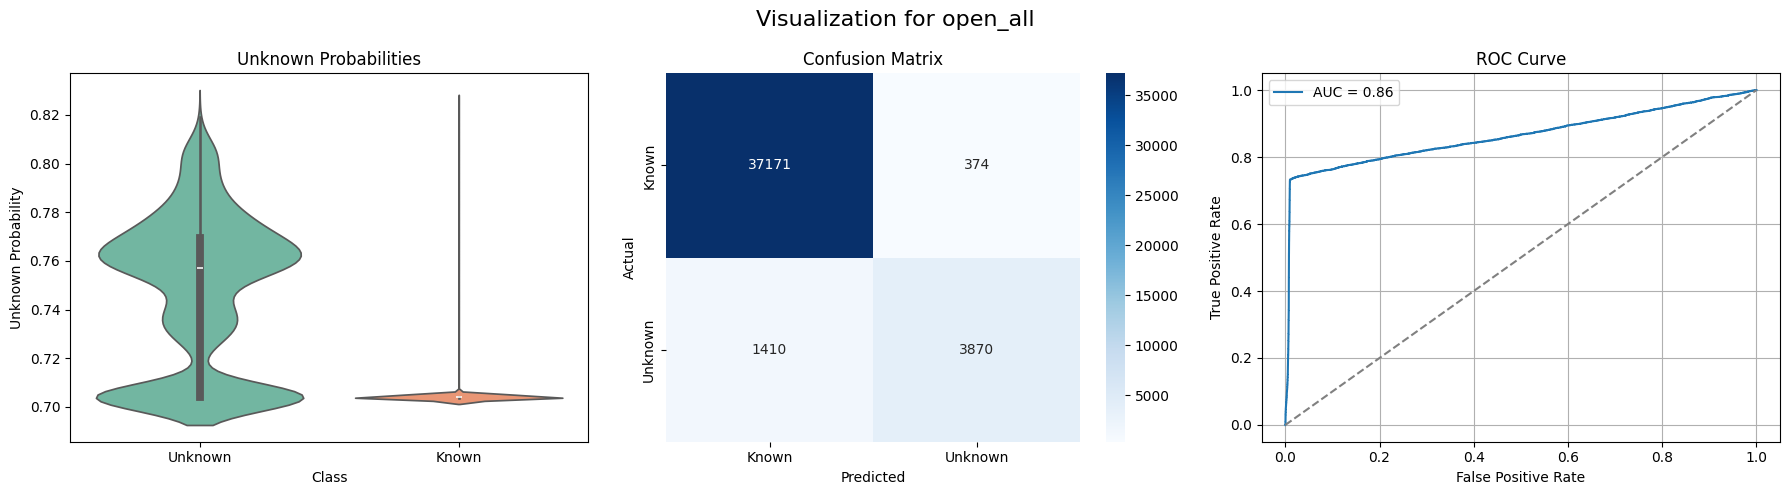

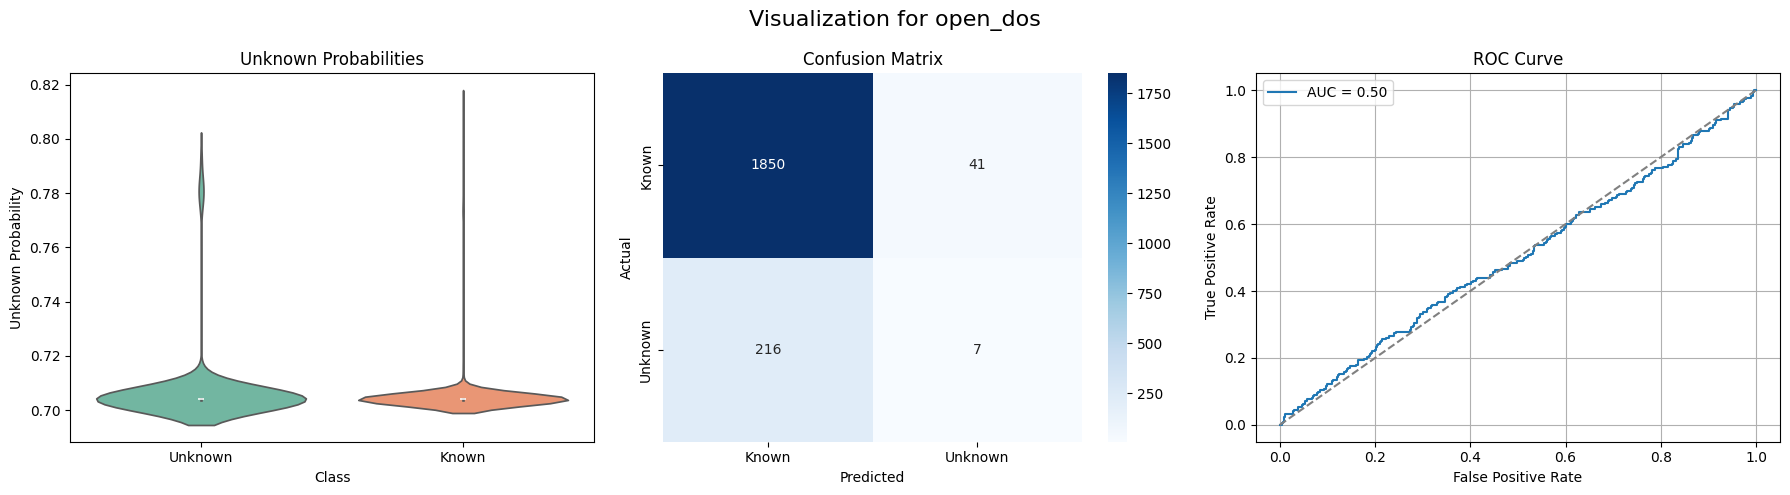

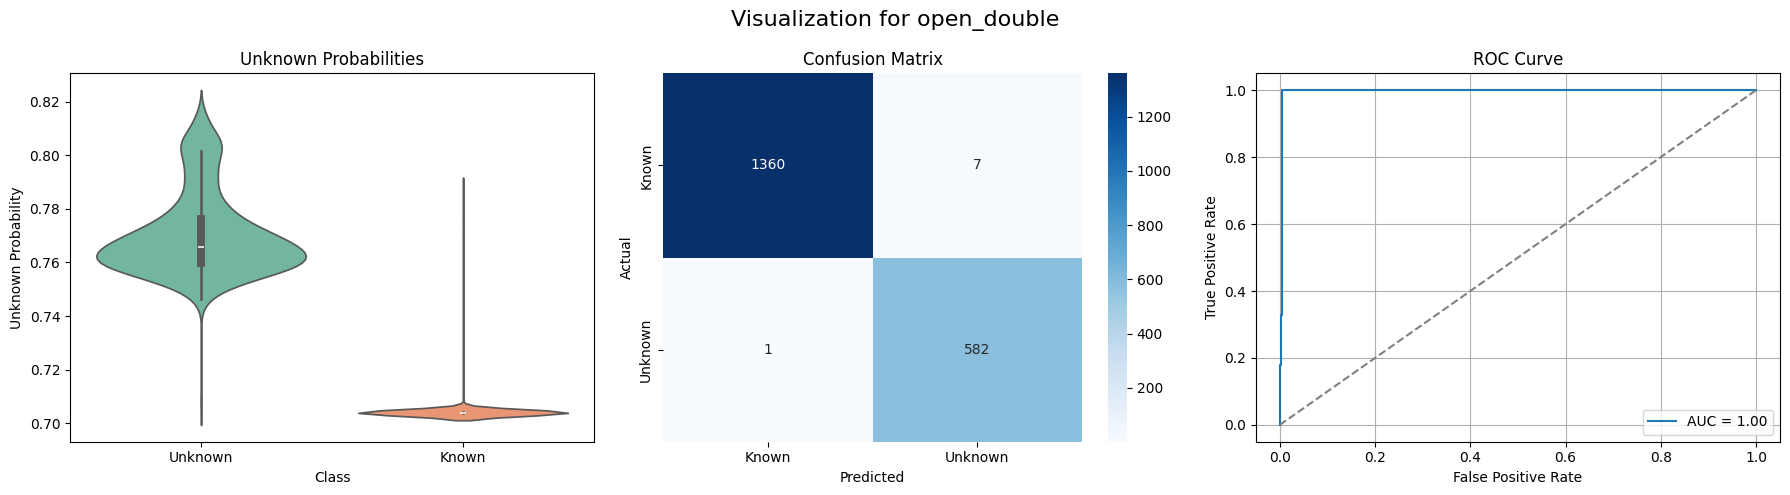

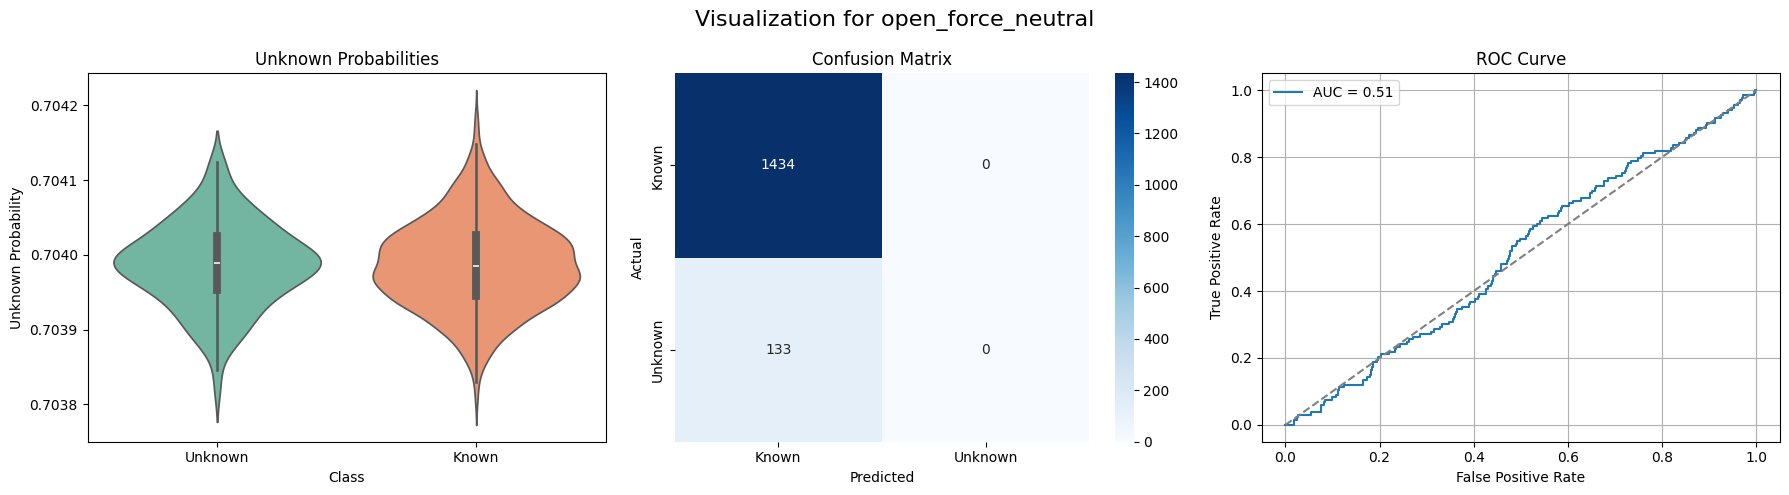

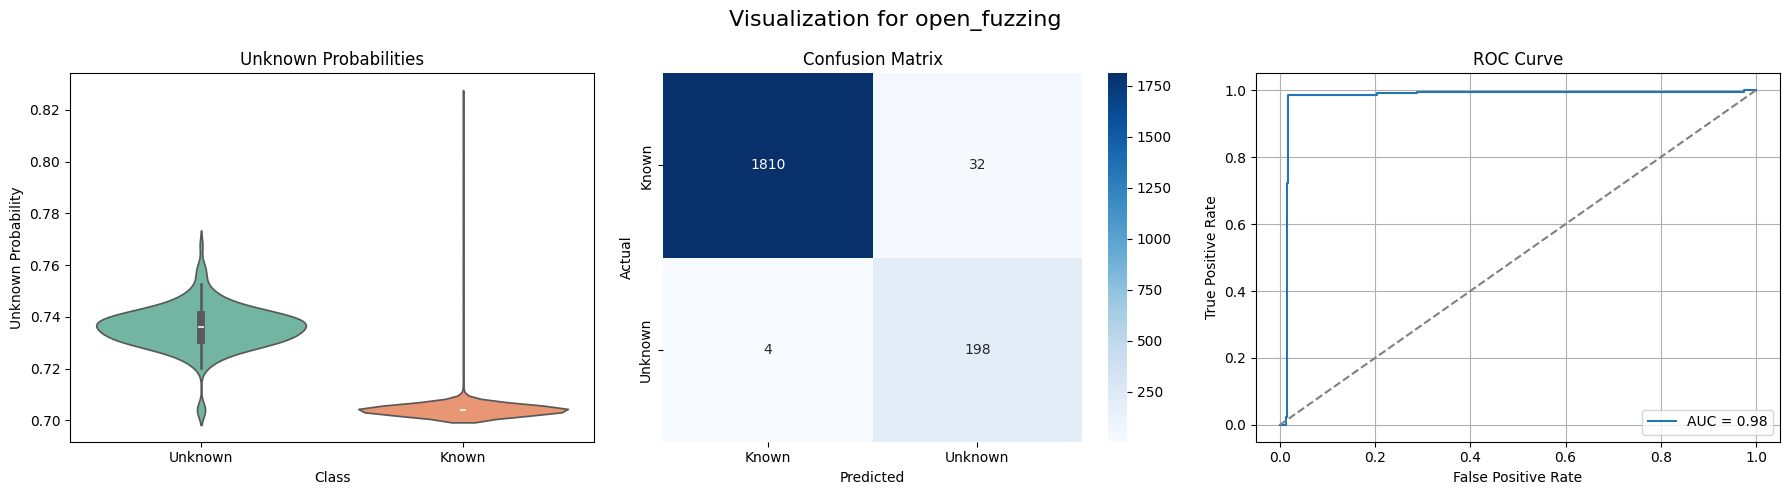

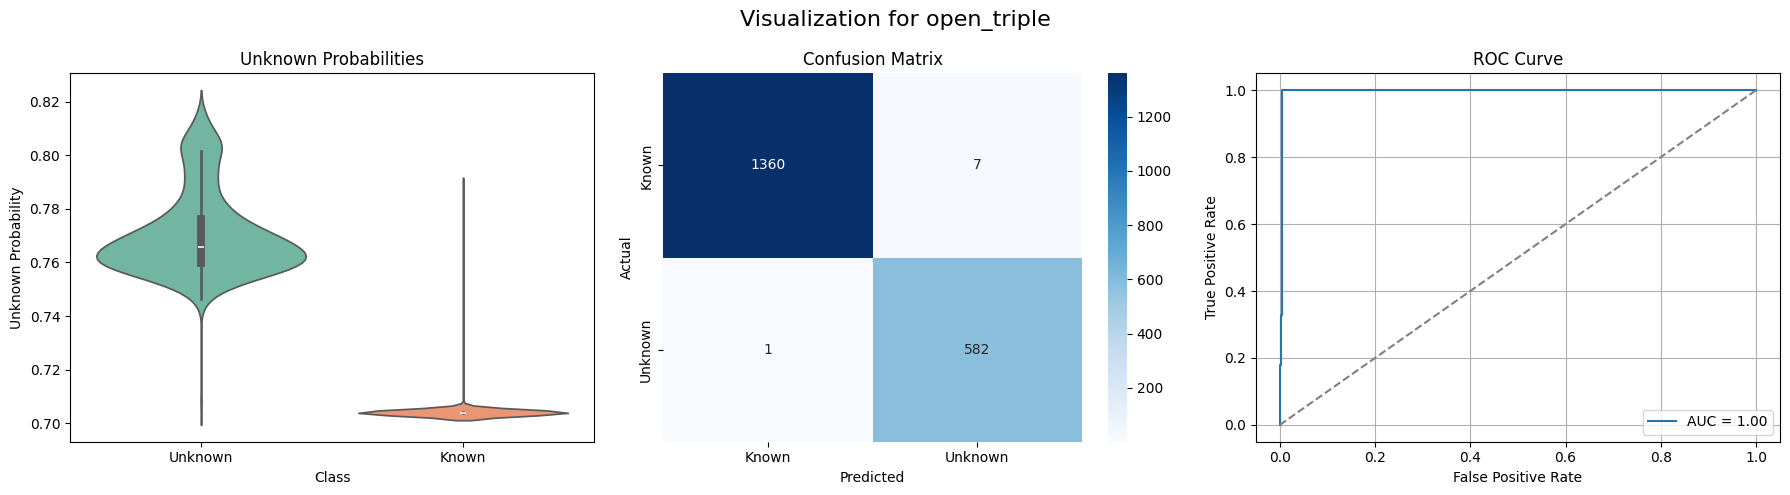

In [130]:
for name, res in results.items():
    plot_all_metrics(res, dataset_name=name)


In [29]:
from sklearn.metrics import silhouette_score
score = silhouette_score(tsne_feats, preds_subset)
print("Silhouette score:", score)


Silhouette score: 0.5017978
